# Ensemble Learning

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

In [2]:
class Tree:
    def __init__(self,branch_value=None,split_feature=None,leaf_value=None):     
        self.branch_value = branch_value
        self.split_feature = split_feature
        self.leaf_value = leaf_value
        self.children = []

    def is_leaf(self):
        return self.leaf_value is not None

    def add_child(self, node):
        self.children.append(node)

    def copy(self):
        new = Tree(self.branch_value, self.split_feature, self.leaf_value)
        new.children = [c.copy() for c in self.children]
        return new



class DecisionTree:
    def __init__(self,alpha = 0, max_depth = 15):
        self.tree = None
        self.alpha = alpha
        self.max_depth = max_depth

    def calculate_entropy(self,col):
        col = np.array(col)
        len_col = len(col)
        entropy = 0
        for val in np.unique(col):
            n = np.count_nonzero(col == val)
            p = n/len_col
            if p>0: entropy -= p * np.log2(p)
        return entropy

    def calculate_avg_entropy(self,col,y):
        col = pd.Series(col) 
        y = pd.Series(y)
        avg_entropy = 0
        len_col = len(col)
        for val,sub_col in col.groupby(col,observed=False):
            y_val = y[sub_col.index]
            entropy_val = self.calculate_entropy(y_val)
            avg_entropy += len(sub_col) / len_col * entropy_val
        return avg_entropy
    
    def chi_square_test(self, X, y, feature_name):
        contingency_table = pd.crosstab(X[feature_name], y)
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        return p_value

    def find_max_gain(self,X,y):
        max_gain = None,None
        for col in X.columns:
            p_value = self.chi_square_test(X, y, col)
            if self.alpha > 0 and p_value >= self.alpha:
                continue
            gain = self.calculate_entropy(y) - self.calculate_avg_entropy(X[col],y)
            if (max_gain[1] is None) or (max_gain[1] < gain) : max_gain = col,gain
        return max_gain
    
    def build_branch(self, X, y, node, depth=0):
        if len(np.unique(y)) == 1 or depth == self.max_depth:
            node.leaf_value = y.mode()[0]
            node.split_feature = None
            return

        best_feature, best_gain = self.find_max_gain(X, y)
        if best_gain is None:
            node.leaf_value = y.mode()[0]
            node.split_feature = None
            return

        node.split_feature = best_feature
        node.leaf_value = None

        for val in np.unique(X[best_feature]):
            sub_X = X[X[best_feature] == val]
            sub_y = y[X[best_feature] == val]

            child = Tree(branch_value=val)
            node.add_child(child)

            self.build_branch(sub_X, sub_y, child, depth + 1)

    def evaluation(self,X_val,y_val):
        accuracy = np.mean(np.array(self.predict(X_val) == y_val))
        return accuracy
    
    def subtree_replacement(self,X_val,y_val,node):
        if node.is_leaf : return
        
        cur_perform = self.evaluation(X_val,y_val)
        cur_node = node.copy()

        node.is_leaf = True
        node.children = []

        pruned_perform = self.evaluation(X_val, y_val)

        if pruned_perform >= cur_perform: return

        else: 
            node.is_leaf = cur_node.is_leaf
            node.val = cur_node.val
            node.name = cur_node.name
            node.children = cur_node.children

    def fit(self,X,y):
        self.fallback_class = y.mode()[0]
        self.tree = Tree()
        self.build_branch(X, y, self.tree)


    def predict(self, X):
        labels = []
        for _, row in X.iterrows():
            cur = self.tree
            while not cur.is_leaf():
                fv = cur.split_feature
                v  = row[fv]
                for child in cur.children:
                    if child.branch_value == v:
                        cur = child
                        break
                else:
                    cur = Tree(leaf_value=self.fallback_class)
                    break
            labels.append(cur.leaf_value)
        return labels
    
    def post_prune(self, X_val, y_val, node=None):
        if node is None:
            node = self.tree

        for child in node.children:
            self.post_prune(X_val, y_val, child)

        self.subtree_replacement(X_val, y_val, node)


In [3]:
df = pd.read_csv('../data/dt_data.csv')
df

,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Yes,No,Yes,Yes,19,Female,NaN,Normal,Positive
1,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
...,...,...,...,...,...,...,...,...,...
344,Yes,No,Yes,No,80,Female,High,High,Positive
345,Yes,No,Yes,No,85,Male,High,High,Positive
346,Yes,No,Yes,No,85,Male,High,High,Positive
347,Yes,No,Yes,No,90,Female,High,High,Positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Fever                 349 non-null    object
 1   Cough                 349 non-null    object
 2   Fatigue               349 non-null    object
 3   Difficulty Breathing  349 non-null    object
 4   Age                   349 non-null    int64 
 5   Gender                349 non-null    object
 6   Blood Pressure        331 non-null    object
 7   Cholesterol Level     315 non-null    object
 8   Outcome Variable      349 non-null    object
dtypes: int64(1), object(8)
memory usage: 24.7+ KB


In [5]:
df['Blood Pressure'] = df['Blood Pressure'].fillna(df['Blood Pressure'].mode()[0])
df['Cholesterol Level'] = df['Cholesterol Level'].fillna(df['Cholesterol Level'].mode()[0])

In [6]:
print(df['Age'].describe())

count    349.000000
mean      46.323782
std       13.085090
min       19.000000
25%       35.000000
50%       45.000000
75%       55.000000
max       90.000000
Name: Age, dtype: float64


In [7]:
df['Age'] = pd.cut(df['Age'],bins=[18,30,45,60,90], labels = ['Young', 'Adult', 'Middle-aged', 'Senior'])
print(df['Age'].describe())

count       349
unique        4
top       Adult
freq        152
Name: Age, dtype: object


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns='Outcome Variable')
y = df['Outcome Variable']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
encoders = {}
for col in X.columns:
    encoder = LabelEncoder()
    encoder.fit(X[col])
    X_train[col] = encoder.transform(X_train[col])
    X_val[col] = encoder.transform(X_val[col])
    encoders[col] = encoder

In [9]:
base_dt_model = DecisionTree(max_depth=10)
base_dt_model.fit(X_train,y_train)

pre_pruning_model = DecisionTree(alpha=0.2,max_depth=5)
pre_pruning_model.fit(X_train,y_train)

post_pruning_model = DecisionTree(max_depth=10)
post_pruning_model.fit(X_train,y_train)
post_pruning_model.post_prune(X_val,y_val)

In [10]:
print(f'Base score: {base_dt_model.evaluation(X_val,y_val):.3f}')
print(f'Pre-Pruning score: {pre_pruning_model.evaluation(X_val,y_val):.3f}')
print(f'Post-Pruning score: {post_pruning_model.evaluation(X_val,y_val):.3f}')

Base score: 0.700
Pre-Pruning score: 0.714
Post-Pruning score: 0.700


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_base = base_dt_model.predict(X_val)
y_pred_pre = pre_pruning_model.predict(X_val)
y_pred_post = post_pruning_model.predict(X_val)
print(f'Base report:\n {classification_report(y_val,y_pred_base)}')
print(f'Pre-pruning report:\n {classification_report(y_val,y_pred_pre)}')
print(f'Post-pruning report:\n {classification_report(y_val,y_pred_post)}')

Base report:
               precision    recall  f1-score   support

    Negative       0.67      0.73      0.70        33
    Positive       0.74      0.68      0.70        37

    accuracy                           0.70        70
   macro avg       0.70      0.70      0.70        70
weighted avg       0.70      0.70      0.70        70

Pre-pruning report:
               precision    recall  f1-score   support

    Negative       0.71      0.67      0.69        33
    Positive       0.72      0.76      0.74        37

    accuracy                           0.71        70
   macro avg       0.71      0.71      0.71        70
weighted avg       0.71      0.71      0.71        70

Post-pruning report:
               precision    recall  f1-score   support

    Negative       0.67      0.73      0.70        33
    Positive       0.74      0.68      0.70        37

    accuracy                           0.70        70
   macro avg       0.70      0.70      0.70        70
weighted avg     

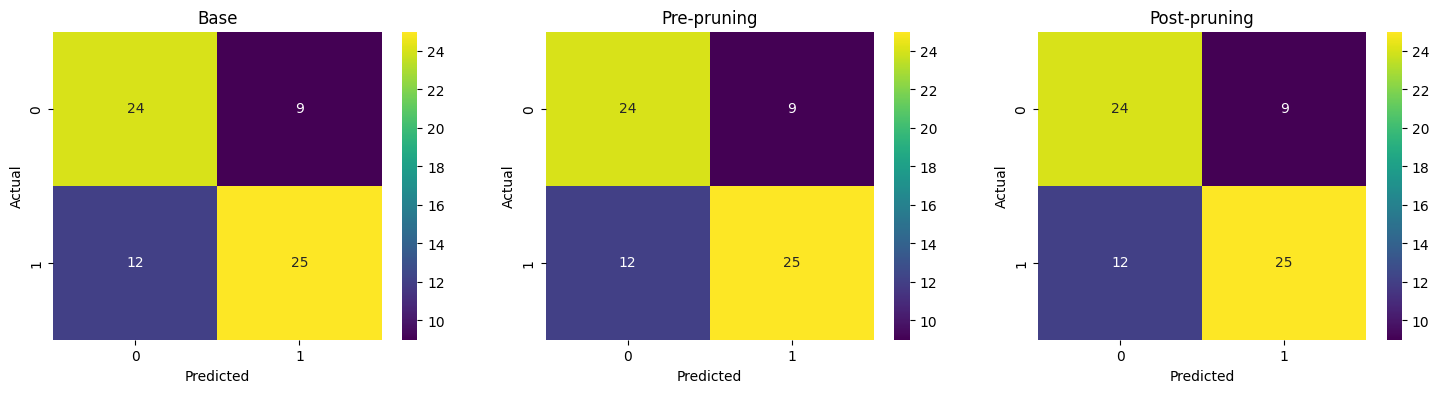

In [17]:
base_cm = confusion_matrix(y_val,y_pred_base)
pre_cm = confusion_matrix(y_val,y_pred_pre)
post_cm = confusion_matrix(y_val,y_pred_post)

titles = ['Base','Pre-pruning','Post-pruning']

fig, axes = plt.subplots(1,3,figsize=(18,4))
for i in range(3):
    sns.heatmap(base_cm,cmap='viridis',annot=True,fmt='d',ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

In [13]:
from sklearn.utils import resample
class RandomForest:
    def __init__(self, n_estimators=50, alpha=0.2, max_depth=5):
        self.n_estimators = n_estimators
        self.alpha = alpha
        self.max_depth = max_depth
        self.forest = []

    def fit(self,X,y):
        for i in range(self.n_estimators):
            X_sample, y_sample = resample(X, y)

            X_sample = X_sample.reset_index(drop=True)
            y_sample = y_sample.reset_index(drop=True)
            tree = DecisionTree(alpha=self.alpha,max_depth=self.max_depth)
            tree.fit(X_sample,y_sample)
            self.forest.append(tree)
    
    def predict(self,X):
        preds = np.array([tree.predict(X) for tree in self.forest])

        labels = []
        for votes in preds.T:
            majority = pd.Series(votes).mode().iloc[0]
            labels.append(majority)
        return labels
    
    def score(self,X_val,y_val):
        accuracy = np.mean(np.array(self.predict(X_val) == y_val))
        return accuracy

In [14]:
rf_model = RandomForest()

rf_model.fit(X_train,y_train)

print(f'RandomForest score: {rf_model.score(X_val,y_val):.3f}')

RandomForest score: 0.729


In [15]:
y_pred_rf = rf_model.predict(X_val)
print(f'RandomForest report:\n {classification_report(y_val,y_pred_rf)}')

RandomForest report:
               precision    recall  f1-score   support

    Negative       0.72      0.70      0.71        33
    Positive       0.74      0.76      0.75        37

    accuracy                           0.73        70
   macro avg       0.73      0.73      0.73        70
weighted avg       0.73      0.73      0.73        70



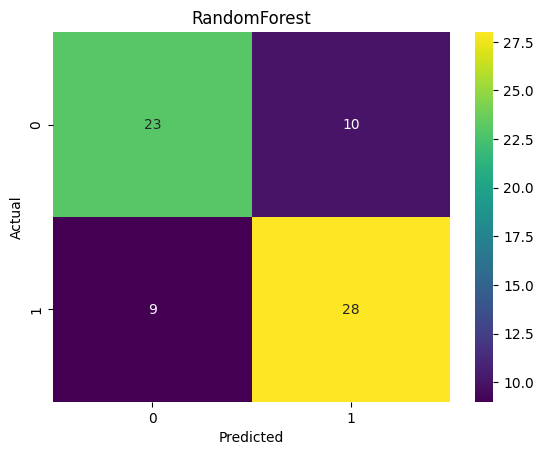

In [16]:
sns.heatmap(confusion_matrix(y_val,y_pred_rf),annot=True,fmt='d',cmap='viridis')
plt.title('RandomForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()